<a href="https://colab.research.google.com/github/nekoradiation/National-Diet-Library/blob/master/KOKURITSU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

# 1.   データの種類と評価方法

> 詳しくはHP参照（https://signate.jp/competitions/218）
*    資料画像に対して、予測対象のレイアウトラベルを含む矩形領域を、bounding box =(x1, y1, x2, y2) として割り当て、且つラベルの1つを付与。
*    各画像には、1つ以上の bounding boxが割り当てらる。
*    bounding box は画像の左上を原点（0,0）とし、オブジェクト領域の左上の座標（x1, y1）、右下の座標（x2, y2）の4つを指定することで表現される。
*    予測対象となるレイアウトラベルは、「古典籍資料」と「明治期以降刊行資料」で異なるため注意。

# 1.1 評価方法


> 評価対象（予測対象）となるレイアウトラベル
（ラベル名	説明）
*    1_overall	資料範囲全体
*    2_handwritten	くずし字の文字ライン
*    3_typography	くずし字以外の文字ライン
*    4_illustration	イラスト（写真含む）
*    5_stamp	印影（蔵書印等）
*    6_headline	見出し
*    7_caption	図表見出し
*    8_textline	6_headline, 7_caption 以外の文字ライン

> ※ラベル「9_table（表）」は、学習用データセットには含まれますが、評価対象（予測対象）からは外します。


# 1.1.1 評価関数
*    評価関数「mean IoU」を使用します。
*    評価値は0～1の値をとり、精度が高いほど大きな値となります。


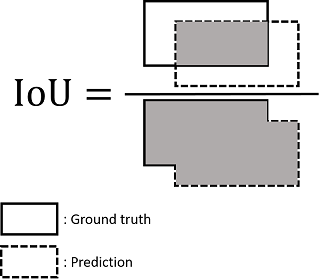

> 評価関数の詳細
*    ①全ラベルの予測領域と正解領域（矩形）の重なり（IoU）を計算
*    ②各画像に対して、ラベル毎の平均IoUを計算
*    ③各画像に対して、画像毎の平均IoU（②の平均値）を計算
*    ④評価対象の全画像の平均IoU（③の平均値）を計算





# 2.   今回とる手法

    * 　カスケード分類
    *   手法B
# 3.   どうしよっかな
# 4.   思いつかないな








# 前準備

In [1]:
#Driveへ接続
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# データの読み込み




In [0]:
#下準備
import json
from collections import OrderedDict
import pprint
import pandas as pd
import numpy as np

In [3]:
#Train Dataのアノテーションを確認
with open('/content/gdrive/My Drive/Colab Notebooks/KOKURITSU/train_annotations/train_1014378_0057.json') as f:
  jsn = json.load(f)
pprint.pprint(jsn, width=40)

{'attributes': {'URL': 'http://dl.ndl.go.jp/info:ndljp/pid/1014378',
                'タイトル': '浮世絵聚英 : '
                        '京都帝室博物館特別展覧',
                'データ公開': '可',
                '公開範囲': 'インターネット公開（保護期間満了）',
                '冊数（ページ数・大きさ）': '図版72枚 '
                                '; '
                                '42cm',
                '出版年': '大正12',
                '出版者': '京都帝室博物館',
                '年代': '近代',
                '著者': '京都帝室博物館 編'},
 'labels': [{'box2d': {'x1': 63,
                       'x2': 1779,
                       'y1': 64,
                       'y2': 1210},
             'category': '1_overall'},
            {'box2d': {'x1': 401,
                       'x2': 609,
                       'y1': 226,
                       'y2': 1038},
             'category': '4_illustration'},
            {'box2d': {'x1': 627,
                       'x2': 641,
                       'y1': 246,
                       'y2': 347},
             'category': '7_caption'},
 

In [4]:
#attributesとlabelsを別々に取得
attributes = jsn['attributes']
labels = jsn['labels']

#attributes内の'年代'を取得
nendai = attributes['年代']
print("年代: {}".format(nendai))

#labelsの各情報を取得
print("各座標点: {}".format(labels[0]['box2d']))
print("種類の分け方: {}".format(labels[0]['category']))

年代: 近代
各座標点: {'x1': 63, 'y1': 64, 'x2': 1779, 'y2': 1210}
種類の分け方: 1_overall


In [5]:
print(labels[1]['box2d']['x1'])

401


In [21]:
#box2dの個数
point_len = len(labels)
point_number = (point_len)

all_list = []
category_list = []
#座標要素を抽出
for i in range(point_number):
    #print("要素{}".format(i))
    object_list = []
    point_list = []
    point_category = labels[i]['category']
    point_list = [point_category]
    for point_object in labels[i]['box2d'].values():
        object_list.append(point_object)
    category_list.append(labels[i]['category'])
    all_list = all_list + object_list
   
np_all_list = np.array(all_list,dtype=np.float32)
np_category_list = np.array(category_list)
np_all_list = np_all_list.reshape(int(point_number), 4)

print(np_all_list)
print(category_list)

[[  63.   64. 1779. 1210.]
 [ 401.  226.  609. 1038.]
 [ 627.  246.  641.  347.]
 [ 632.  368.  646.  469.]]
['1_overall', '4_illustration', '7_caption', '7_caption']


In [27]:
np_all_list_t = np_all_list.T
print(np_all_list_t)

[[  63.   64. 1779. 1210.]
 [ 401.  226.  609. 1038.]
 [ 627.  246.  641.  347.]
 [ 632.  368.  646.  469.]]


In [28]:
#上記情報を一つのpandasファイルにまとめる
train_1 = pd.DataFrame(np_all_list_t)
#一覧表に変換
train_1

,0,1,2,3
0,63.0,64.0,1779.0,1210.0
1,401.0,226.0,609.0,1038.0
2,627.0,246.0,641.0,347.0
3,632.0,368.0,646.0,469.0




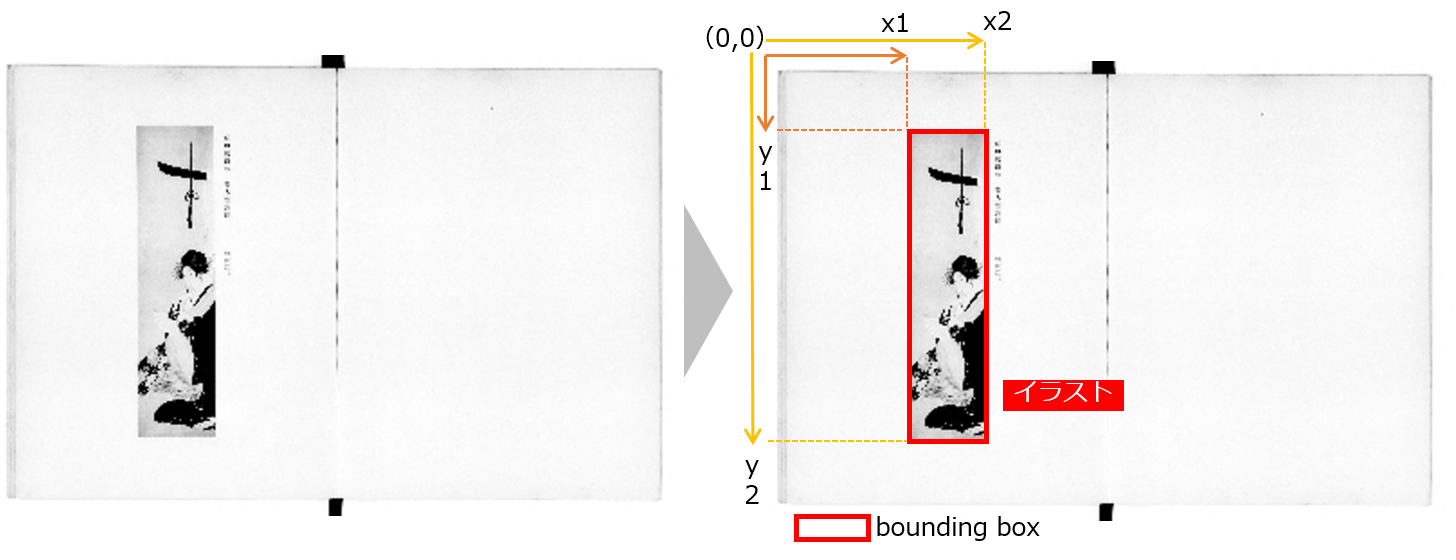

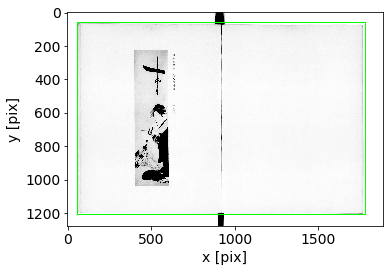

確認x1:63.0 x2:1779.0 y1:64.0 y21210.0


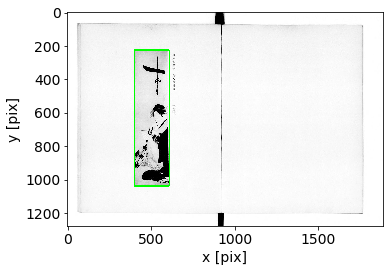

確認x1:401.0 x2:609.0 y1:226.0 y21038.0


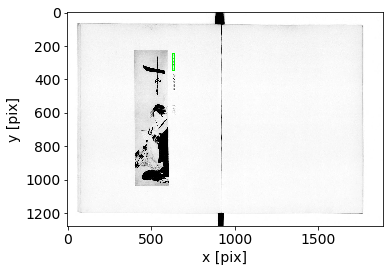

確認x1:627.0 x2:641.0 y1:246.0 y2347.0


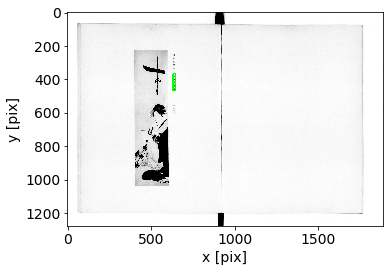

確認x1:632.0 x2:646.0 y1:368.0 y2469.0


In [47]:
#cv2で画像に重ねる
import cv2
from matplotlib import pyplot as plt

path = '/content/gdrive/My Drive/Colab Notebooks/KOKURITSU/train_images/train_1014378_0057.jpg'
img = cv2.imread(path, 1)

for data in np_all_list_t:
    path = '/content/gdrive/My Drive/Colab Notebooks/KOKURITSU/train_images/train_1014378_0057.jpg'
    img = cv2.imread(path, 1)

    x1 = data[0]
    y1 = data[1]
    x2 = data[2]
    y2 = data[3]

    #obj = img[y1:y2, x1:x2]
    # matplotlibの表示に合わせてRGBの順番に色を並び替える。
    i = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
    # ここからグラフ設定
    # フォントの種類とサイズを設定する。
    plt.rcParams['font.size'] = 14
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    #
    i2 = cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0),thickness=5)

    # 画像をプロット
    ax1.imshow(i)
    ax1.imshow(i2)
 
    # 軸のラベルを設定する。
    ax1.set_xlabel('x [pix]')
    ax1.set_ylabel('y [pix]')
    fig.tight_layout()
    plt.show()

    print("確認x1:{} x2:{} y1:{} y2{}".format(x1, x2, y1, y2))

上記の作業をファイル内のjsonに対してすべて行っていく